<a href="https://colab.research.google.com/github/jax-ml/bonsai/blob/main/bonsai/models/unet/tests/UNet_segmentation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Segmentation with U-Net (Work in progress)**

This notebook demonstrates how to use the U-Net model from the Bonsai library to perform a simple image segmentation task.

*This colab demonstrates the U-Net implementation from the [Bonsai library](https://github.com/jax-ml/bonsai).*

## **1. Set-up**

In [1]:
%%capture
!pip install -q git+https://github.com/jax-ml/bonsai@main
!pip install -q pillow matplotlib scikit-image
!pip install tqdm -q
!pip uninstall -y jax jaxlib
!pip install -U "jax[cuda12]"

In [2]:
from pathlib import Path

import jax
import jax.extend
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import orbax.checkpoint as ocp
import tensorflow as tf
import tensorflow_datasets as tfds
from flax import nnx
from flax.training.train_state import TrainState
from tqdm import tqdm

from bonsai.models.unet import modeling as unet_lib
from bonsai.models.unet import params as params_lib

print(f"JAX version: {jax.__version__}")
print(f"JAX device: {jax.extend.backend.get_backend().platform}")

JAX version: 0.9.0.1
JAX device: gpu


## **2. Load Data and Train the Model**

To test the U-Net architecture, we will generate a simple synthetic image with basic shapes. The goal is to make the model predict a mask that highlights these shapes.

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 8


def load_dataset(batch_size=BATCH_SIZE, image_size=IMAGE_SIZE):
    """Loads and preprocesses a subset of the Oxford-IIIT Pet dataset."""
    ds_builder = tfds.builder("oxford_iiit_pet")
    ds_builder.download_and_prepare()
    # Using smaller splits for faster demonstration
    train_split, test_split = ds_builder.as_dataset(split=["train[:50%]", "test[:50%]"])

    def preprocess(sample):
        image = tf.image.resize(sample["image"], (image_size, image_size))
        mask = tf.image.resize(sample["segmentation_mask"], (image_size, image_size), method="nearest")
        image = tf.cast(image, tf.float32) / 255.0
        # The mask values are 1, 2, 3. We subtract 1 to make them 0, 1, 2.
        mask = tf.squeeze(mask - 1, axis=-1)
        return image, mask

    train_ds = train_split.map(preprocess).cache().shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_split.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return tfds.as_numpy(train_ds), tfds.as_numpy(test_ds)


def segmentation_loss(logits: jax.Array, labels: jax.Array) -> jax.Array:
    """Computes softmax cross-entropy loss for segmentation."""
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    return jnp.mean(loss)


config = unet_lib.ModelConfig(in_channels=3, num_classes=3)
rngs = nnx.Rngs(0)

# Create the model from scratch with random initial weights
model = params_lib.create_model(cfg=config, rngs=rngs)

# Split the model into its structure (graphdef) and its state (variables)
graphdef, model_state = nnx.split(model)

# This is how you get the initial, random weights for training from scratch.
params = model_state.filter(nnx.Param)

# Extract non-trainable variables
other_vars = model_state.filter(lambda path, value: not isinstance(value, nnx.Param))

optimizer = optax.adam(learning_rate=1e-3)

train_state = TrainState.create(apply_fn=graphdef.apply, params=params, tx=optimizer)


@jax.jit
def train_step(state: TrainState, other_vars: nnx.State, batch: tuple[jax.Array, jax.Array]):
    """Performs a single training step."""
    images, masks = batch

    def loss_fn(params):
        # Recombine the graph, TRAINED params, and OTHER_VARS to build the full model
        model = nnx.merge(graphdef, params, other_vars)

        # Forward pass, converting the output proxy to a JAX array
        logits = jnp.asarray(model(images))

        # Calculate loss
        loss = segmentation_loss(logits, masks)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


print("Starting training from scratch...")
train_loader, _ = load_dataset()
num_epochs = 100
state = train_state

for epoch in range(num_epochs):
    total_loss = 0
    batch_count = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for images, masks in pbar:
        state, loss = train_step(state, other_vars, (images, masks))
        total_loss += loss
        batch_count += 1

        if batch_count > 0:
            avg_loss = total_loss / batch_count
            pbar.set_postfix(loss=f"{avg_loss:.4f}")

print("Training finished!")

Starting training from scratch...


Epoch 100/100: 100%|██████████| 230/230 [00:12<00:00, 18.40it/s, loss=0.0677]

Training finished!


## **3. Save the Weights**

In [4]:
ckpt_dir = Path("./checkpoints")
ckpt_dir.mkdir(exist_ok=True)

# Use Orbax to save the PyTree of the model's parameters directly
checkpointer = ocp.PyTreeCheckpointer()

# Save state.params instead of the merged state
checkpointer.save(ckpt_dir.resolve(), item=state.params, force=True)

print(f"Model parameters saved to: {ckpt_dir.resolve()}")

Model parameters saved to: /content/checkpoints


## **4. Prepare U-Net Model for Inference**

Now let's prepare the U-Net model from the Bonsai library. We will configure it for an input with 3 channels (like our RGB synthetic image) and 1 output class (for binary segmentation).

In [5]:
from pathlib import Path

import jax
import orbax.checkpoint as ocp
from flax import nnx

from bonsai.models.unet import modeling as unet_lib
from bonsai.models.unet import params as params_lib

IMAGE_SIZE = 128


def load_test_data(num_images, seed=42):
    ds_builder = tfds.builder("oxford_iiit_pet")
    ds_builder.download_and_prepare()
    test_split = ds_builder.as_dataset(split="test")

    def preprocess(sample):
        image = tf.image.resize(sample["image"], (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    buffer_size = ds_builder.info.splits["test"].num_examples
    test_ds = test_split.shuffle(buffer_size, seed=seed).map(preprocess).take(num_images).batch(num_images)
    return next(iter(tfds.as_numpy(test_ds)))


print("Preparing model for inference...")

# This provides the necessary structure (the "graphdef").
config = unet_lib.ModelConfig(in_channels=3, num_classes=3)
rngs = nnx.Rngs(params=0)
template_model = params_lib.create_model(cfg=config, rngs=rngs)
graphdef, _ = nnx.split(template_model)  # We only need the static graphdef

# b. Use the parameters from the previous training step or load from checkpoint.
if "state" in locals():
    loaded_params = state.params
else:
    ckpt_dir = Path("./checkpoints")
    checkpointer = ocp.PyTreeCheckpointer()
    loaded_params = checkpointer.restore(ckpt_dir.resolve())

# c. Merge the graphdef with the loaded parameters to create a complete, trained model.
inference_model = nnx.merge(graphdef, loaded_params)
print("Model ready for inference!")

Preparing model for inference...
Model ready for inference!


## **5. Run Inference**

We will now perform a forward pass with our synthetic image through the trained U-Net. The output should be a valid segmentation mask.

In [6]:
print("Preparing data and running prediction...")

# a. Load a batch of 5 images from the test set.
image_batch = load_test_data(num_images=10)


# b. Define the JIT-compiled prediction function.
@jax.jit
def predict(model, images):
    logits = model(images)
    # Get the predicted class (0, 1, or 2) for each pixel
    return jnp.argmax(logits, axis=-1)


# c. Run the prediction.
predicted_masks = predict(inference_model, image_batch)

print(f"Prediction complete. Output shape: {predicted_masks.shape}")

Preparing data and running prediction...
Prediction complete. Output shape: (10, 128, 128)


## **6. Visualize Results**

Let's visualize the input image, the ground truth mask, and the mask predicted by the trained model. The predicted mask should closely match the ground truth, demonstrating the model's ability to segment the image.

Displaying results...


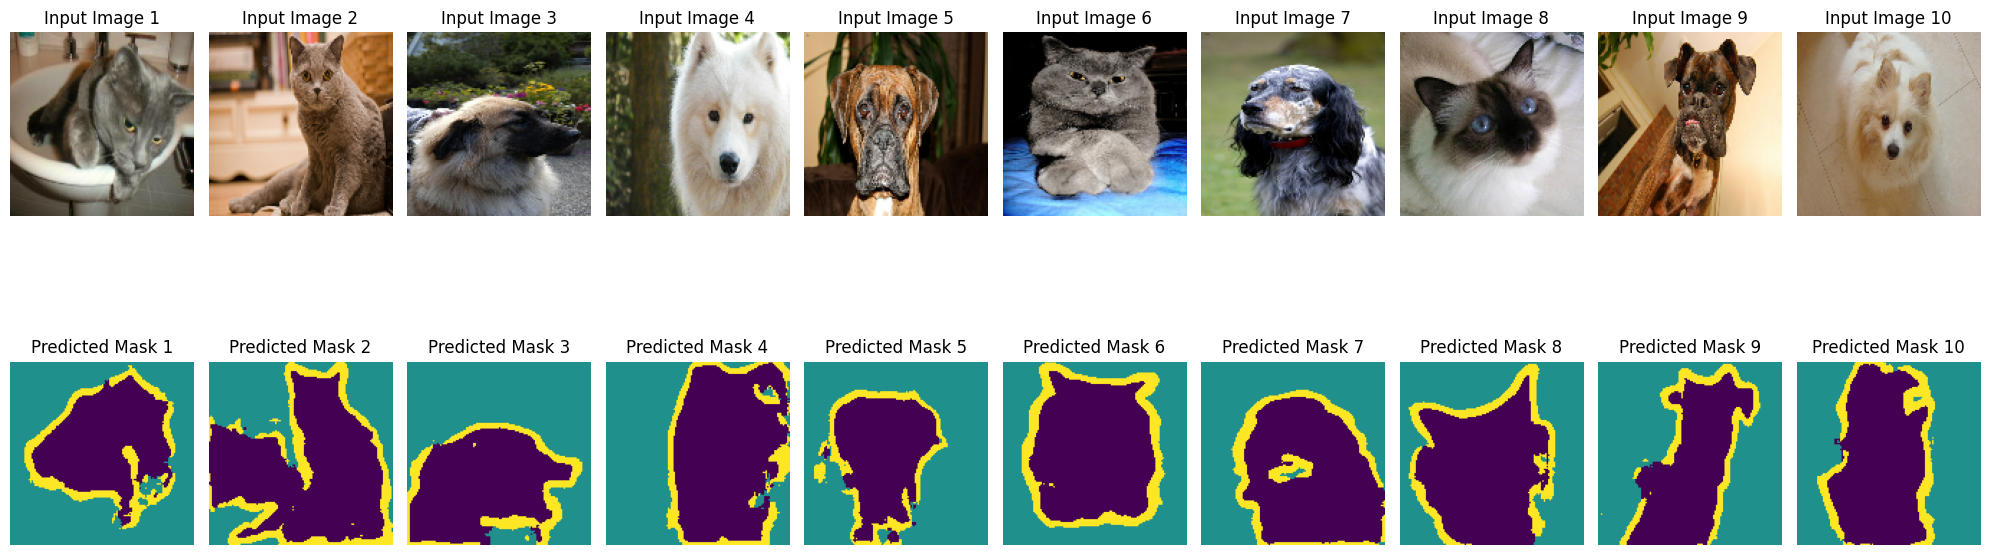


Figure saved as 'unet_segmentation_results.png'


In [7]:
print("Displaying results...")
fig, axes = plt.subplots(2, 10, figsize=(20, 8))
for i in range(10):
    # Plot original image
    axes[0, i].imshow(image_batch[i])
    axes[0, i].set_title(f"Input Image {i + 1}")
    axes[0, i].axis("off")

    # Plot predicted mask
    axes[1, i].imshow(predicted_masks[i], cmap="viridis")
    axes[1, i].set_title(f"Predicted Mask {i + 1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.savefig("unet_segmentation_results.png", dpi=150)
plt.show()

print("\nFigure saved as 'unet_segmentation_results.png'")

## **Conclusion**

This notebook demonstrates how to set up and run the Bonsai U-Net model. Here you can:

1. **Instantiated the U-Net model** with a specific configuration.
2. **Created synthetic data** for a simple segmentation task.
3. **Performed a forward pass** to get the model's output logits.
4. **Visualized the output**, confirming the model learned to segment the image.